# Mitochondrial redistribution following RSV1 infection

In [1]:
%matplotlib inline
import os
import javabridge
import bioformats
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyome as ome
import seaborn as sns
from functools import reduce
from itertools import chain
from matplotlib import transforms
from mito import mito, plot

In [2]:
javabridge.start_vm(class_path=bioformats.JARS, max_heap_size="8G")

In [3]:
mito_18_rescue_path = "/Users/keithschulze/Google Drive/Projects/Jans Lab/data/For Keith- Mitochondrial organization relative to gamma-tubulin/18h p.i. RSV samples (inc. rescued mito organization)"
output_path = os.path.join(mito_18_rescue_path, "210617")

dmso_mock = os.path.join(mito_18_rescue_path, "Vehicle or DMSO on mock.lif")
dmso_rsv = os.path.join(mito_18_rescue_path, "Vehicle or DMSO on RSV infected .lif")
nocodazale_rsv = os.path.join(mito_18_rescue_path, "Nocodazale on RSV infected.lif")
ehna_rsv = os.path.join(mito_18_rescue_path, "EHNA on RSV infected .lif")

mito_18_rescue_input = [(dmso_mock, "Mock", "DMSO", output_path),
                        (dmso_rsv, "RSV1", "DMSO", output_path),
                        (nocodazale_rsv, "RSV1", "NOCODAZALE", output_path),
                        (ehna_rsv, "RSV1", "EHNA", output_path)]

min_nuc_distance = 10
min_nuc_area = 500
min_mito_area = 10
rsv_threshold = 10

r90, angs = map(pd.concat, 
                zip(*reduce(chain, 
                            (mito.process_file(pth, inf, t, out, 
                                          min_nucleus_distance=min_nuc_distance,
                                          min_nucleus_area=min_nuc_area,
                                          min_mito_area=min_mito_area, 
                                          infection_threshold=rsv_threshold)
                             for pth, inf, t, out in mito_18_rescue_input))))

In [4]:
# Plot angular distribution of mitochondria relative to MTOC on polar histogram. MTOC at 0°.
sns.set(font_scale=1.5)
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style("whitegrid")

In [5]:
## Output number of cells analysed
r90.groupby(['Pathogen', 'Treatment']).size().to_csv(os.path.join(output_path, "cell_counts.csv"))

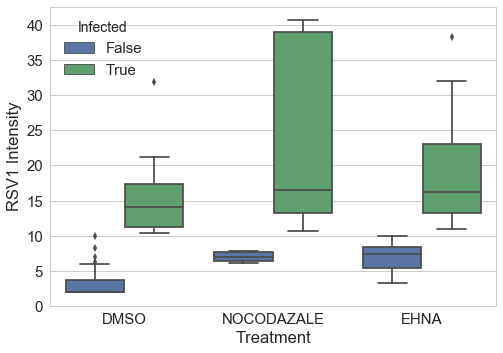

In [6]:
# Plot distribution of mean RSV1 intensity
sns.boxplot(x="Treatment", y="RSV1 Intensity", hue="Infected", data=r90)

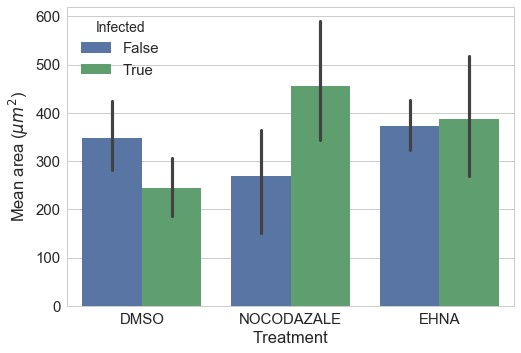

In [7]:
# Plot mean mitochondria area
area_fig, ax1 = plt.subplots()
sns.barplot(x="Treatment", y="Area", hue="Infected", data=r90, ax=ax1)
ax1.set_xlabel("Treatment")
ax1.set_ylabel(r"Mean area ($\mu m^2$)")

In [8]:
# Save area plot
area_fig.savefig(os.path.join(output_path, "area_plt.pdf"))

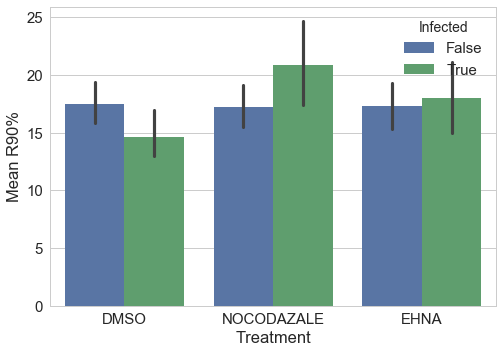

In [9]:
# Plot mean R90%
r90_fig, ax1 = plt.subplots()
sns.barplot(x="Treatment", y="R90%", hue="Infected", data=r90, ax=ax1)
ax1.set_xlabel("Treatment")
ax1.set_ylabel("Mean R90%")

In [10]:
# Save R90% figure
r90_fig.savefig(os.path.join(output_path, "r90_plt.pdf"))

In [11]:
# Save Area and R90% data frame
r90.to_csv(os.path.join(output_path, "rsv.csv"))

## Summarise angular distribution of mitochondria relative to the MTOC
In this case a ɣ-tubulin marker was introduced to mark the MTOC. The is therefore to determine whether contraction of the mitochondria correlates spatially with the MTOC region.

In [12]:
# Calculate angles in degrees and calculate proportion of mitochondria within 90° of MTOC
angs["Angle"] = np.rad2deg(angs["Mitochondria angle"])
freq90 = angs.groupby(['Infected', 'Treatment', 'Name', 'Cell ID'])['Angle'].agg(mito.frequency90).reset_index()

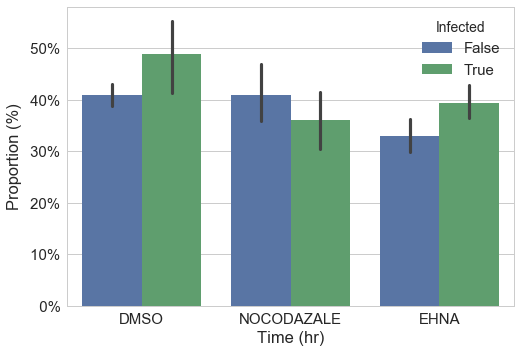

In [14]:
# Plot proportion of mitochondria within 90° of MTOC
freq90_plt, freq90_ax = plt.subplots()
sns.barplot(x = 'Treatment', y = 'Angle', hue = 'Infected', hue_order = [False, True], 
            order = ['DMSO', 'NOCODAZALE', 'EHNA'], data = freq90, ci=68)

vals = freq90_ax.get_yticks()
freq90_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
freq90_ax.set_xlabel("Time (hr)")
freq90_ax.set_ylabel("Proportion (%)")

In [15]:
# Save plot and dataframe
freq90_plt.savefig(os.path.join(output_path, "freq90deg_plt.pdf"))
freq90.to_csv(os.path.join(output_path, "freq90deg.csv"))

In [ ]:
# Plot distribution of mitochondria relative to MTOC on histogram. MTOC at 0°.
g = sns.FacetGrid(angs, row="Infected", col="Treatment",
#                   subplot_kws=dict(projection='polar'), 
                  size=4.5, sharex=False, sharey=True, despine=False)

# Draw a scatterplot onto each axes in the grid
# g = (g.map(plt.hist, "Mitochondria angle", bins = 50, normed=True)
# #       .set(theta_direction=-1, theta_zero_location="N", ylim=(0,0.7))
#       .fig.subplots_adjust(hspace=.3))
g.map(plot.vertical_line, "Angle", color="red")

(g.map(sns.distplot, "Angle")
#   .set(theta_direction=-1, theta_zero_location="N", ylim=(0,0.012))
  .set(xlim=(-180, 180), xticks=[-180, -135, -90, -45, 0, 45, 90, 135, 180])
  .set_xlabels(r'Angle ($^\circ$)')
  .fig.subplots_adjust(hspace=.3))

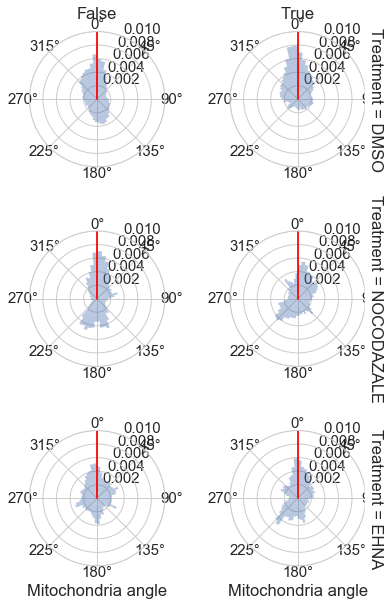

In [21]:
# Plot angular distribution of mitochondria relative to MTOC on polar histogram. MTOC at 0°.
y_ticks = np.array([0.002, 0.004, 0.006, 0.008, 0.01])
g = sns.FacetGrid(angs, row="Treatment", col="Infected",
                  subplot_kws=dict(projection='polar'), 
                  size=3, aspect=1.0, sharex=False, sharey=False,
                  despine=False, margin_titles=True)

# Draw a scatterplot onto each axes in the grid
# g = (g.map(plt.hist, "Mitochondria angle", bins = 50, normed=True)
# #       .set(theta_direction=-1, theta_zero_location="N", ylim=(0,0.7))
#       .fig.subplots_adjust(hspace=.3))
g.map(plot.vertical_line, "Mitochondria angle", color="red")

(g.map(plot.polar_hist, "Mitochondria angle", bins=60, density=True)
  .set(theta_direction=-1,
       theta_zero_location="N", 
       ylim=(0, 0.01), 
       yticks=y_ticks)
  .set_titles(col_template="{col_name}", row_template=""))

In [22]:
axes = g.fig.axes
thetaticks = np.arange(0,360,45)

for ax in axes:
    for c in ax.get_children():
        if isinstance(c, mpl.text.Annotation):
            c.remove()
    
    ax.set_yticklabels([])
    ax.xaxis.label.set_visible(False)
    ax.set_thetagrids(thetaticks, frac=1.2)
    ttl = ax.title
    ttl.set_position([0.5, 1.2])
    
# g.fig.tight_layout(pad=1)

factor = 1
d = axes[0].get_yticks()[-1] * factor
r_tick_labels = [0] + axes[0].get_yticks().tolist()
r_ticks = (np.array(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_ticks = np.arcsin(d / r_ticks) #+ np.pi / 2
r_axlabel = (np.mean(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_axlabel = np.arcsin(d / r_axlabel) #+ np.pi / 2

# fixed offsets in x
offset_spine = transforms.ScaledTranslation(-170, 0, axes[0].transScale)
offset_ticklabels = transforms.ScaledTranslation(-10, 0, axes[0].transScale)
offset_axlabel = transforms.ScaledTranslation(-50, 0, axes[0].transScale)

# apply these to the data coordinates of the line/ticks
trans_spine = axes[0].transData + offset_spine
trans_ticklabels = trans_spine + offset_ticklabels
trans_axlabel = trans_spine + offset_axlabel

# plot the 'spine'
#axes[0].plot(theta_ticks, r_ticks, '-_k', transform=trans_spine,
#            clip_on=False)
axes[0].plot(theta_ticks, r_ticks, '-_', c="gray", linewidth=0.8, ms=10, markerfacecolor='gray',
             markeredgewidth=0.8, transform=trans_spine,
             clip_on=False)

# plot the 'tick labels'
for ii in range(len(r_ticks)):
    axes[0].text(theta_ticks[ii], r_ticks[ii], "%.3f" % r_tick_labels[ii],
                 ha="right", va="center", clip_on=False, fontsize='smaller',
                 transform=trans_ticklabels)

# plot the 'axis label'
axes[0].text(theta_axlabel, r_axlabel, 'Density', fontsize='large', rotation='vertical',
             ha='right', va='center', clip_on=False, transform=trans_axlabel)

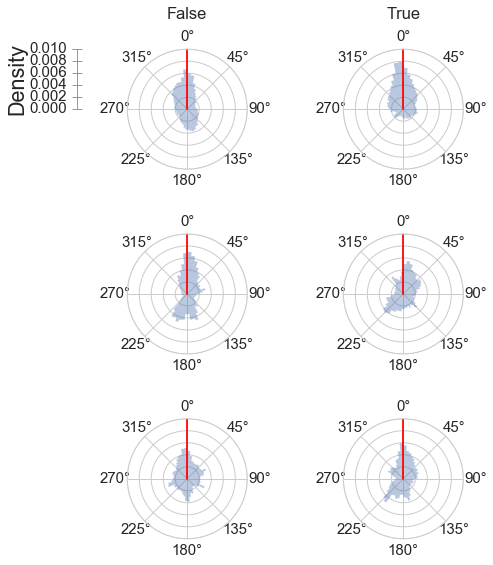

In [23]:
g.fig.subplots_adjust(wspace=0.8, hspace=-0.1)
# g.fig.subplots_adjust(hspace=0.8)
g.fig

In [24]:
# Save polar histogram
g.savefig(os.path.join(output_path, "mito_angle_polar_vert.pdf"))

In [20]:
# Save angle data
angs.to_csv(os.path.join(output_path, "angles.csv"))

In [25]:
javabridge.kill_vm()